In [26]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, classification_report

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset


In [2]:
#Check GPU:

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
train_path = "../data/raw/train.csv"

df = pd.read_csv(train_path)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df["target"].value_counts(normalize=True).round(3)

target
0    0.57
1    0.43
Name: proportion, dtype: float64

In [5]:
#Train/validation split

X = df["text"].astype(str).tolist()
y = df["target"].astype(int).tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

len(X_train), len(X_val)

(6090, 1523)

#### Create Hugging Face Dataset objects

In [6]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df   = pd.DataFrame({"text": X_val,   "label": y_val})

hf_train = Dataset.from_pandas(train_df)
hf_val   = Dataset.from_pandas(val_df)

hf_train, hf_val


(Dataset({
     features: ['text', 'label'],
     num_rows: 6090
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1523
 }))

#### Tokenizer and tokenization function

In [7]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

max_length = 128

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length,
    )

hf_train_tok = hf_train.map(tokenize_batch, batched=True)
hf_val_tok   = hf_val.map(tokenize_batch, batched=True)

hf_train_tok = hf_train_tok.remove_columns(["text"])
hf_val_tok   = hf_val_tok.remove_columns(["text"])

hf_train_tok.set_format("torch")
hf_val_tok.set_format("torch")

hf_train_tok[0]


Map: 100%|██████████| 1523/1523 [00:00<00:00, 3546.31 examples/s]


{'label': tensor(1),
 'input_ids': tensor([  101, 21871,  6508,  2103,  2611,  2406, 15876,  8950, 15577,  1999,
         20629,  3137,  4586, 19718,  1001, 20118,  5244,  8299,  1024,  1013,
          1013,  1056,  1012,  2522,  1013, 25930,  2243,  6593,  4779, 16150,
          2683,  1001, 21307, 14659, 14301,  2063,  1001,  2338,  5092, 14122,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

#### Load DistilBERT model

In [8]:
num_labels = 2

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

model.to(device)


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 182.77it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Metrics function

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }


#### TrainingArguments + Trainer

In [ ]:
batch_size = 16  # if OOM on GPU/CPU, reduce to 8
epochs = 3

training_args = TrainingArguments(
    output_dir="../models/bert-distil",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="../logs/bert",
    logging_steps=50,
    report_to="none",  # turn off WandB etc.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    compute_metrics=compute_metrics,
)


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


#### Train

In [11]:
trainer.train()

d:\Projects\disaster-tweet-detection\vvenv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.449347,0.371735,0.853578,0.881416,0.761468,0.817063
2,0.341072,0.412213,0.834537,0.797337,0.824159,0.810526
3,0.232373,0.423527,0.841103,0.824921,0.799694,0.812112


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]
d:\Projects\disaster-tweet-detection\vvenv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
d:\Projects\disaster-tweet-detection\vvenv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1143, training_loss=0.3423144005936483, metrics={'train_runtime': 6739.4057, 'train_samples_per_second': 2.711, 'train_steps_per_second': 0.17, 'total_flos': 605044843361280.0, 'train_loss': 0.3423144005936483, 'epoch': 3.0})

#### Final evaluation and classification report

In [12]:
eval_results = trainer.evaluate()
eval_results


d:\Projects\disaster-tweet-detection\vvenv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.3717275857925415,
 'eval_accuracy': 0.8535784635587655,
 'eval_precision': 0.8814159292035398,
 'eval_recall': 0.7614678899082569,
 'eval_f1': 0.8170631665299426,
 'eval_runtime': 125.2885,
 'eval_samples_per_second': 12.156,
 'eval_steps_per_second': 0.383,
 'epoch': 3.0}

In [13]:
pred_outputs = trainer.predict(hf_val_tok)
logits = pred_outputs.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = np.array(y_val)

print("Accuracy :", accuracy_score(y_true, y_pred))
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))


d:\Projects\disaster-tweet-detection\vvenv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Accuracy : 0.8535784635587655
Precision: 0.8814159292035398
Recall   : 0.7614678899082569
F1-score : 0.8170631665299426

Classification report:

              precision    recall  f1-score   support

           0     0.8372    0.9229    0.8779       869
           1     0.8814    0.7615    0.8171       654

    accuracy                         0.8536      1523
   macro avg     0.8593    0.8422    0.8475      1523
weighted avg     0.8562    0.8536    0.8518      1523



#### Simple confusion matrix 

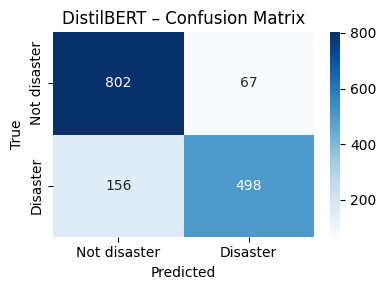

array([[802,  67],
       [156, 498]])

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not disaster", "Disaster"],
    yticklabels=["Not disaster", "Disaster"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DistilBERT – Confusion Matrix")
plt.tight_layout()
plt.show()

cm


#### Save model for later use 

In [15]:
save_dir = "../models/bert-distil-best"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
save_dir


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


'../models/bert-distil-best'

In [17]:
eval_results

{'eval_loss': 0.3717275857925415,
 'eval_accuracy': 0.8535784635587655,
 'eval_precision': 0.8814159292035398,
 'eval_recall': 0.7614678899082569,
 'eval_f1': 0.8170631665299426,
 'eval_runtime': 125.2885,
 'eval_samples_per_second': 12.156,
 'eval_steps_per_second': 0.383,
 'epoch': 3.0}

#### Prediction helper function

In [21]:
import torch
from transformers import DistilBertTokenizerFast

# Load your trained model
model_path = "../models/bert-distil-best"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()


def predict_tweet(text, threshold=0.5):
    """
    Predict disaster tweet with adjustable threshold.
    
    Args:
        text (str): Tweet text
        threshold (float): Probability threshold for "disaster"
    
    Returns:
        dict: prediction, confidence, logits, threshold_used
    """
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    ).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()[0]
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    # Apply threshold
    p_disaster = probs[1]  # probability of disaster (class 1)
    prediction = 1 if p_disaster >= threshold else 0
    confidence = probs[prediction]  # confidence in the prediction
    
    return {
        "prediction": prediction,  # 1=disaster, 0=not
        "confidence": confidence,
        "p_disaster": p_disaster,
        "logits": logits,
        "threshold_used": threshold,
        "prediction_label": "Disaster" if prediction == 1 else "Not Disaster",
    }


Loading weights: 100%|██████████| 104/104 [00:00<00:00, 156.74it/s, Materializing param=pre_classifier.weight]                                  


In [22]:
test_tweets = [
    "Forest fire near La Ronge Sask. Canada",
    "My presentation was a complete disaster", 
    "Earthquake just hit downtown area",
    "This traffic is killing me",
    "Building collapsed after explosion",
]

thresholds = [0.5, 0.45, 0.4, 0.35]

print("Tweet analysis across thresholds:\n")
print("Tweet" + " " * 40 + "p_disaster  pred@0.5  pred@0.4  pred@0.35")
print("-" * 80)

for tweet in test_tweets:
    p_disaster = predict_tweet(tweet)["p_disaster"]
    
    pred_05 = "✅" if p_disaster >= 0.5 else "❌"
    pred_04 = "✅" if p_disaster >= 0.4 else "❌"
    pred_035 = "✅" if p_disaster >= 0.35 else "❌"
    
    print(f"{tweet[:40]:40} {p_disaster:.3f}  {pred_05:6}  {pred_04:6}  {pred_035:6}")


Tweet analysis across thresholds:

Tweet                                        p_disaster  pred@0.5  pred@0.4  pred@0.35
--------------------------------------------------------------------------------
Forest fire near La Ronge Sask. Canada   0.979  ✅       ✅       ✅     
My presentation was a complete disaster  0.075  ❌       ❌       ❌     
Earthquake just hit downtown area        0.976  ✅       ✅       ✅     
This traffic is killing me               0.091  ❌       ❌       ❌     
Building collapsed after explosion       0.965  ✅       ✅       ✅     


In [27]:
# Get predictions on validation set across thresholds
val_predictions = []
val_probs = []

for text in X_val:
    result = predict_tweet(text)
    val_predictions.append(result["prediction"])
    val_probs.append(result["p_disaster"])

val_probs = np.array(val_probs)
val_true = np.array(y_val)

thresholds = np.arange(0.3, 0.8, 0.05)
results = []

for thresh in thresholds:
    preds = (val_probs >= thresh).astype(int)
    acc = accuracy_score(val_true, preds)
    prec = precision_score(val_true, preds, zero_division=0)
    rec = recall_score(val_true, preds, zero_division=0)
    f1 = f1_score(val_true, preds, zero_division=0)
    
    results.append({
        "threshold": thresh,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

results_df = pd.DataFrame(results)
results_df


,threshold,accuracy,precision,recall,f1
0,0.30,0.845043,0.824534,0.811927,0.818182
1,0.35,0.847669,0.841424,0.795107,0.817610
2,0.40,0.851609,0.855482,0.787462,0.820064
3,0.45,0.850295,0.863481,0.773700,0.816129
4,0.50,0.853578,0.881416,0.761468,0.817063
5,0.55,0.848982,0.881295,0.749235,0.809917
6,0.60,0.848326,0.890943,0.737003,0.806695
7,0.65,0.848326,0.907514,0.720183,0.803069
8,0.70,0.846356,0.913386,0.709480,0.798623
9,0.75,0.841103,0.925620,0.685015,0.787346


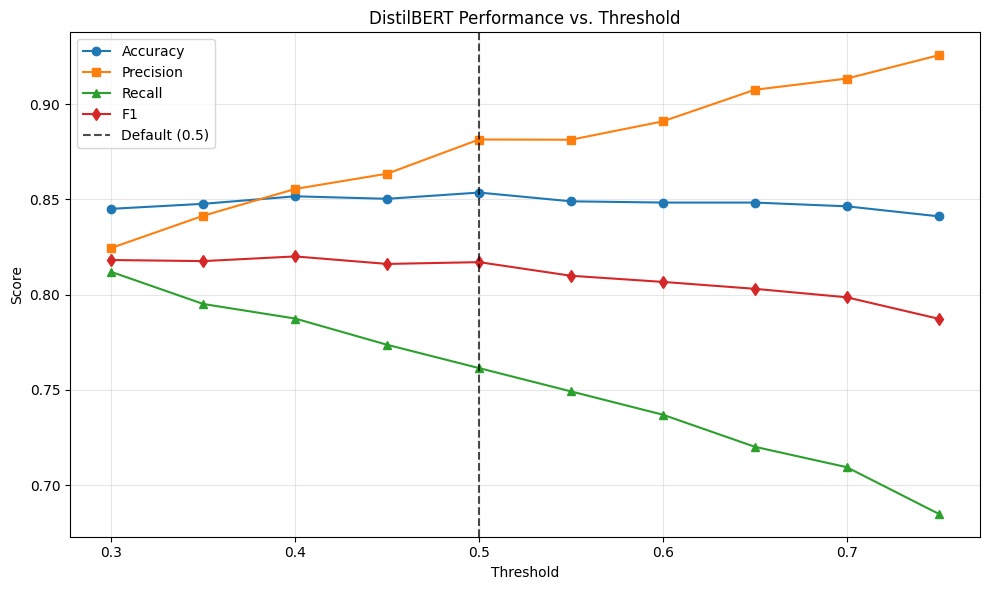

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(results_df["threshold"], results_df["accuracy"], marker="o", label="Accuracy")
ax.plot(results_df["threshold"], results_df["precision"], marker="s", label="Precision")
ax.plot(results_df["threshold"], results_df["recall"], marker="^", label="Recall")
ax.plot(results_df["threshold"], results_df["f1"], marker="d", label="F1")

ax.axvline(x=0.5, color="k", linestyle="--", alpha=0.7, label="Default (0.5)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("DistilBERT Performance vs. Threshold")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Final prediction function

In [29]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
import re
import numpy as np


class DisasterTweetPredictor:
    """
    Production-ready predictor using your fine-tuned DistilBERT.
    
    Usage: predictor.predict("tweet text")
    """
    
    def __init__(self, model_path="../models/bert-distil-best", threshold=0.40):
        self.threshold = threshold
        
        # Load model
        self.tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.model.eval()
        
        print(f"✅ Loaded model to {self.device}")
        print(f"   Using threshold: {threshold:.2f}")
    
    def predict(self, text):
        """
        Predict disaster tweet.
        
        Args:
            text (str): Raw tweet text
            
        Returns:
            dict: prediction, confidence, explanation
        """
        # Minimal cleaning (BERT likes natural text)
        text = re.sub(r"http\S+", "", text)  # URLs only
        text = text.strip()
        
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128,
        ).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits.cpu().numpy()[0]
            probs = torch.nn.functional.softmax(
                torch.tensor(logits), dim=-1
            ).numpy()
        
        p_disaster = probs[1]
        prediction = 1 if p_disaster >= self.threshold else 0
        confidence = probs[prediction]
        
        # Simple explanation
        disaster_keywords = [
            "fire", "earthquake", "flood", "accident", "crash", 
            "explosion", "disaster", "emergency", "destroyed"
        ]
        keywords_found = [kw for kw in disaster_keywords if kw in text.lower()]
        
        explanation = "Disaster keywords detected" if keywords_found else "No strong keywords"
        
        return {
            "prediction": prediction,
            "prediction_label": "🚨 DISASTER" if prediction == 1 else "✅ NOT DISASTER",
            "confidence": float(confidence),
            "p_disaster": float(p_disaster),
            "threshold": self.threshold,
            "explanation": explanation,
            "keywords_found": keywords_found,
            "raw_probs": probs.tolist(),
        }


# Test it
predictor = DisasterTweetPredictor(threshold=0.40)

test_tweet = "Forest fire near La Ronge Sask. Canada"
result = predictor.predict(test_tweet)
result


Loading weights: 100%|██████████| 104/104 [00:00<00:00, 300.97it/s, Materializing param=pre_classifier.weight]                                  


✅ Loaded model to cpu
   Using threshold: 0.40


{'prediction': 1,
 'prediction_label': '🚨 DISASTER',
 'confidence': 0.9788894653320312,
 'p_disaster': 0.9788894653320312,
 'threshold': 0.4,
 'explanation': 'Disaster keywords detected',
 'keywords_found': ['fire'],
 'raw_probs': [0.02111051417887211, 0.9788894653320312]}

In [30]:
# Quick validation set test with new threshold
val_results = []
for text in X_val[:100]:  # test first 100 for speed
    result = predictor.predict(text)
    val_results.append(result)

val_pred = [r["prediction"] for r in val_results]
val_true = y_val[:100]

print("Threshold 0.40 on first 100 val samples:")
print(f"Accuracy: {accuracy_score(val_true, val_pred):.4f}")


Threshold 0.40 on first 100 val samples:
Accuracy: 0.7900
